In [1]:
import sys 
from scipy.interpolate import RegularGridInterpolator


sys.path.append("/users/tom/git/neon_blink_detection/")
sys.path.append("/users/tom/git/neon_blink_detection/src")

from src.features_calculator import create_grids
import numpy as np

from training.video_loader import video_loader
from src.helper import OfParams, AugParams
of_params = OfParams()
aug_params = AugParams()

clip_name = "1322-2023-02-03-14-25-41-7883a14f"

of_params = OfParams(n_layers=3, layer_interval=7, average=False, img_shape=(64, 64), grid_size=15, step_size=5, window_size=11, stop_steps=3)

rec = video_loader(of_params, aug_params)

rec._load(clip_name, bg_ratio=3, augment=False)


/cluster/anaconda3/envs/tom_py310/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Number of clips: 2


In [168]:
feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies

n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)

# only take y direction
feature_array = clip_feature_array[0][:, :, 1]
timestamps = clip_timestamps[0]
t = (timestamps - timestamps[0]) / 1e9

of_left = np.reshape(feature_array[:, :400], (-1,20,20))
of_right = np.reshape(feature_array[:, 400:], (-1,20,20))

In [146]:
timestamps, eye_left_images, eye_right_images = rec._get_frames(clip_name, convert_to_gray=True)

t = (timestamps - timestamps[0]) / 1e9

# where difference in frames is larger than 100 ms
clip_transitions = np.where(np.diff(timestamps) > 1e8)[0]

n_clips = clip_transitions.shape[0] + 1
clip_left_images = np.split(eye_left_images, clip_transitions + 1)
clip_right_images = np.split(eye_right_images, clip_transitions + 1)

feature_array = []

for iclip in range(0, n_clips):

    clip_feature_array, grid = rec._compute_optical_flow(
        of_params, clip_left_images[iclip], clip_right_images[iclip]
    )

    feature_array.append(clip_feature_array)

feature_array = np.vstack(feature_array)

deprecated pixel format used, make sure you did set range correctly
 (repeated 294857 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


deprecated pixel format used, make sure you did set range correctly
 (repeated 11834 more times)
deprecated pixel format used, make sure you did set range correctly


deprecated pixel format used, make sure you did set range correctly
 (repeated 142145 more times)
deprecated pixel format used, make sure you did set range correctly


In [157]:
feature_array = feature_array[:, :, 1]

of_left = np.reshape(feature_array[:, :400], (-1,20,20))
of_right = np.reshape(feature_array[:, 400:], (-1,20,20))

In [166]:
feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

feature_array

(3490, 800, 2)

In [291]:
import typing as T

def new_concatenate_features(
    feature_array: np.ndarray, of_params: OfParams, indices: np.ndarray = None
) -> np.ndarray:
    
    def get_layers(n, layer_interval):
        return np.arange(-(n // 2), (n + 1) // 2) * layer_interval
    
    interp_left, interp_right = _create_interpolater(feature_array)
    
    layer_interval = of_params.layer_interval / 200 # sampling rate to convert to ms

    n_frame = len(feature_array)

    if indices is None:
        indices = np.arange(n_frame) / 200

    n_grids = of_params.grid_size * of_params.grid_size * 2
    layers = get_layers(of_params.n_layers, layer_interval)

    indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
    indices_layers = np.clip(indices_layers, 0, len(feature_array) - 1)

    features_left = np.concatenate([interpolate_spacetime(interp_left, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    features_right = np.concatenate([interpolate_spacetime(interp_right, indices, grid_size=of_params.grid_size).reshape(-1, of_params.grid_size**2) for indices in indices_layers], axis=-1)

    return np.concatenate((features_left, features_right), axis=-1)

def _create_interpolater(feature_array: np.ndarray, grid_size=20):

    length = grid_size ** 2

    of_left = np.reshape(feature_array[:, :length], (-1, grid_size, grid_size))
    of_right = np.reshape(feature_array[:, length:], (-1, grid_size, grid_size))

    x = np.linspace(0, 64, grid_size, dtype=np.float32)
    y = np.linspace(0, 64, grid_size, dtype=np.float32)

    interpolator_left = RegularGridInterpolator((t, x, y), of_left, bounds_error=False, fill_value=None, method="linear")
    
    interpolator_right = RegularGridInterpolator((t, x, y), of_right, bounds_error=False, fill_value=None, method="linear")

    return interpolator_left, interpolator_right


def interpolate_spacetime(interpolator, time_points: T.List[int], grid_size: int, augmentation: T.Dict[str, int] = None):
    
    x = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]
    y = np.linspace(0, 64, grid_size + 2, dtype=np.float32)[1:-1]

    tt, xx, yy = np.meshgrid(time_points, x, y)

    txy_grid = np.concatenate((tt.reshape(-1, 1), xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    if augmentation is not None:

        augm_params = get_augmentation_pars()

        grid_trans = np.zeros_like(txy_grid)

        grid_trans = txy_grid[:, 0]
        grid_trans[:, 1:] = (augm_params["linear_distort"] @ (augm_params["scale"] * (txy_grid[:, 1:] - 32.)).T).T + 32 + augm_params["translation"]

        txy_grid = grid_trans
    
    return interpolator(txy_grid).reshape(grid_size, len(time_points), grid_size).transpose(1, 0, 2)
    
def get_augmentation_pars(n_augmentations):
    
    augmentation_params = {}
    
    std_speed = 0.2
    std_translation = 3
    std_scale = 0.15
    std_linear = 0.03
    
    augmentation_params["speed"] = np.random.normal(1, std_speed, n_augmentations)
    augmentation_params["translation"] = np.random.normal(0, std_translation, (n_augmentations, 2))
    augmentation_params["scale"] = np.random.normal(1, std_scale, n_augmentations)
    augmentation_params["linear_distort"] = np.squeeze(np.dstack([np.eye(2)]*n_augmentations) + np.random.normal(0, std_linear, (2, 2, n_augmentations)))
    
    return augmentation_params


In [292]:
get_augmentation_pars(1)["scale"]

array(1.15027843)

**Interpolate to 50x50 grid for 3 points in time**

*Plot result*

KeyboardInterrupt: 

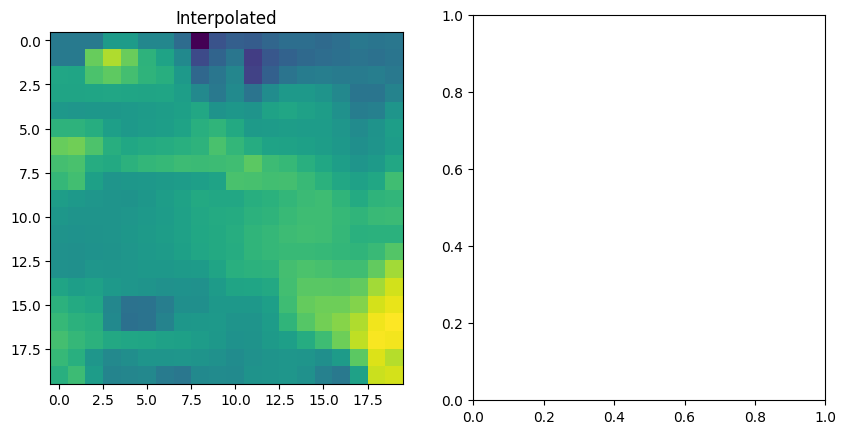

In [235]:
import matplotlib.pyplot as plt

interp_left, interp_right = _create_interpolater(feature_array)

of_interp = interpolate_spacetime(interp_left, t, grid_size=20)

f, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(of_interp[5,:, :])
ax[0].set_title("Interpolated")
                

augm_params = get_augmentation_pars()

p_grid = create_grids((64,64), 20 + 2, full_grid=False) 
p_grid_trans = np.empty_like(p_grid)
p_grid_trans = (linear_distort @ (scale * (p_grid - 32.)).T).T + 32 + translation

of_interp = interpolate_spacetime(interp_left, t, grid_size=20, x=p_grid_trans[:, 0], y=p_grid_trans[:, 1])


ax[1].imshow(of_interp[5, :, :])
ax[1].set_title("Distorted")



In [248]:
x = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]
y = np.linspace(0, 64, 20 + 2, dtype=np.float32)[1:-1]

tt, xx, yy = np.meshgrid(t, x, y)

txy_grid = np.concatenate((tt.reshape(-1, 1), xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

In [249]:
txy_grid.shape

(223200, 3)

{'speed': 0.6138818451458874, 'translation': array([ 1.20328568, -3.54200285]), 'scale': 1.0016356215375843, 'linear_distort': array([[ 1.05412514, -0.0731985 ],
       [ 0.00287418,  0.99703526]])}


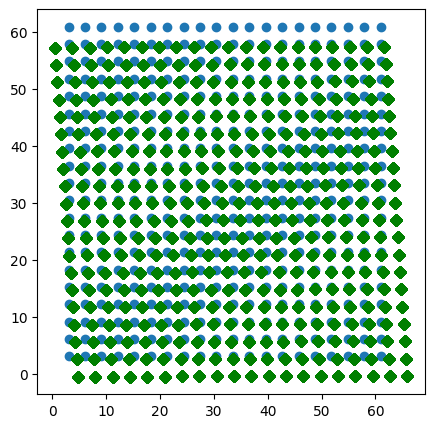

In [261]:


t_trans = augm_params["speed"] * t

fig = plt.figure(figsize=(5,5))
plt.plot(p_grid[:,0], p_grid[:,1],'o')
plt.plot(p_grid_trans[:,0], p_grid_trans[:,1],'gD')

print(augm_params)



In [2]:
import matplotlib.pyplot as plt


from src.features_calculator import (
    new_concatenate_features,
    get_augmentation_pars,
)

feature_array, all_timestamps, clip_transitions = rec._load_features(
            clip_name, rec._of_params)

# Add random sampling of some indicies

n_clips = clip_transitions.shape[0] + 1
clip_feature_array = np.split(feature_array, clip_transitions + 1, axis=0)
clip_timestamps = np.split(all_timestamps, clip_transitions + 1, axis=0)



Number of clips: 2


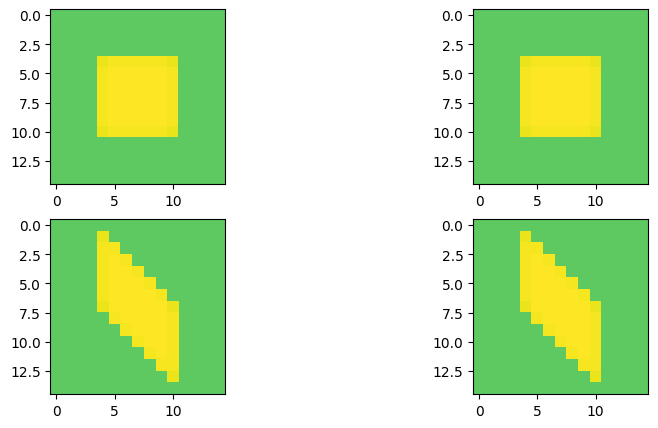

In [116]:
all_times = (all_timestamps[0:10000] - all_timestamps[0]) / 1e9 
indc_times = [2, 500, 1000, 2000, 5000, 10000]

aug_params = get_augmentation_pars()
aug_params["speed"] = 1
aug_params["translation"] = np.zeros((1, 2))
aug_params["scale"] = 1
aug_params["linear_distort"] = np.eye(2)

aug_feat = new_concatenate_features(
    feature_array[0:10000],
    rec._of_params,
    all_times,
    indc_times[0],
    aug_params,
)

left = aug_feat[0, :675].reshape(3, 15, 15)
right = aug_feat[0, 675:].reshape(3, 15, 15)


aug_params = get_augmentation_pars()
aug_params["speed"] = 1
aug_params["translation"] = [0, 0]
aug_params["scale"] = 1


aug_params["linear_distort"] = np.eye(2) + [[0, 0], [0, 0]]

aug_feat = new_concatenate_features(
    feature_array[0:10000],
    rec._of_params,
    all_times,
    indc_times[0],
    aug_params,
)

left_aug = aug_feat[0, :675].reshape(3, 15, 15)
right_aug = aug_feat[0, 675:].reshape(3, 15, 15)


f, ax = plt.subplots(2, 2, figsize=(10, 5))

ax[0, 0].imshow(left[0, :, :], vmin=-3, vmax=1)
ax[0, 1].imshow(right[0, :, :], vmin=-3, vmax=1)
ax[1, 0].imshow(left_aug[0, :, :], vmin=-3, vmax=1)
ax[1, 1].imshow(right_aug[0, :, :], vmin=-3, vmax=1)

In [44]:
feature_array[]


(3490, 800, 2)

In [32]:
of_left = np.zeros([3490, 20, 20, 2])
of_left[:, 6:14, 6:14, :] = 1

of_right = np.zeros([3490, 20, 20, 2])
of_right[:, 6:14, 6:14, :] = 1

of_left = of_left.reshape(-1, 20*20, 2)
of_right = of_right.reshape(-1, 20*20, 2)

feature_array = np.concatenate((of_left, of_right), axis=1)

In [33]:
feature_array.shape

(3490, 800, 2)